In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

df = pd.read_csv('c://users//Sergi//proyectos//proyecto_final//data//processed//vehicles_with_model_clean.csv')


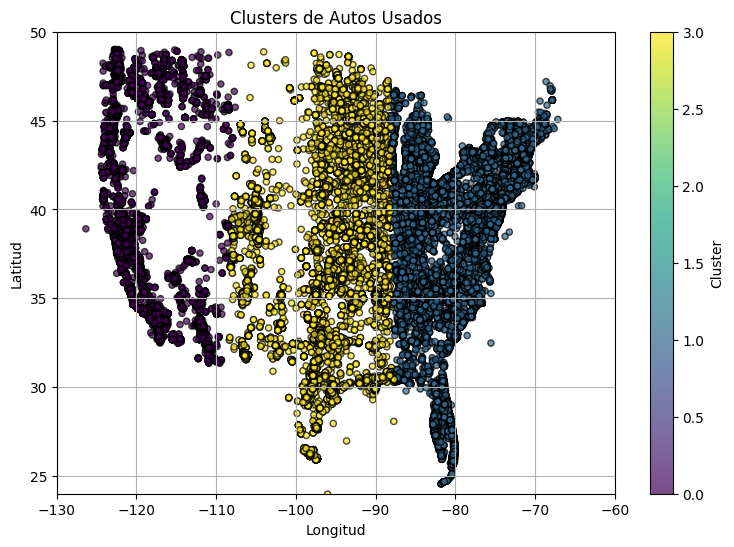

In [4]:
from sklearn.cluster import KMeans

# Extraer las coordenadas de latitud y longitud
coords = df[['lat', 'long']].values

# Definir el número de clusters
n_clusters = 4  # Puedes ajustar este valor según lo necesario

# Aplicar K-Means
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(coords)

# Añadir los labels de los clusters al DataFrame
df['cluster'] = kmeans.labels_

# Graficar los clusters
plt.figure(figsize=(9, 6))
plt.scatter(df['long'], df['lat'], c=df['cluster'], cmap='viridis', marker='o', s=20, alpha=0.7, edgecolor='k')
plt.title('Clusters de Autos Usados')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.xlim(-130, -60)
plt.ylim(24, 50)
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

# Guardar los resultados en un nuevo archivo CSV
# DF.to_csv('ruta/a/tu/archivo_clusters.csv', index=False)


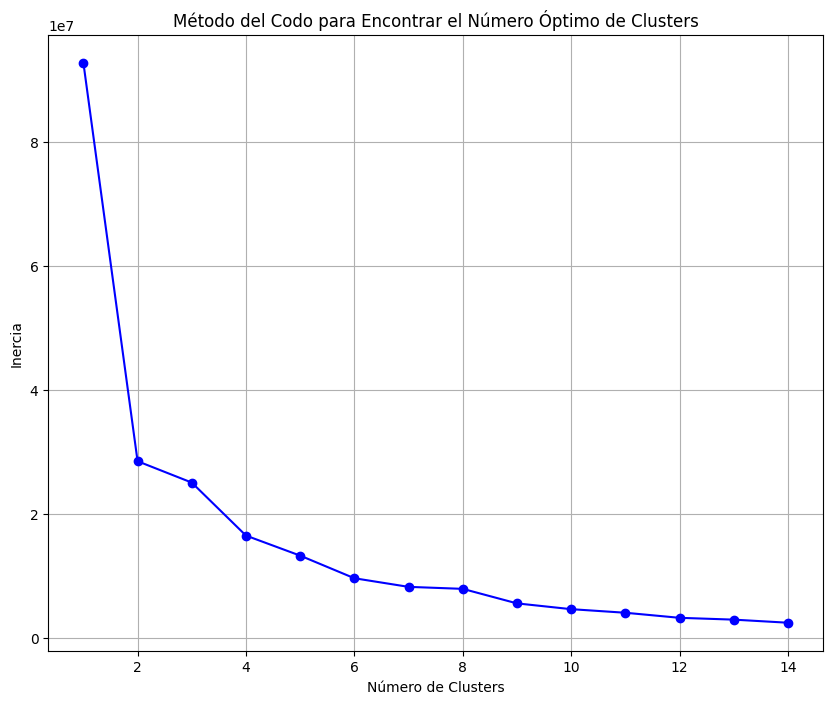

In [ ]:
# Extraer las coordenadas de latitud y longitud
coords = df[['lat', 'long']].values

# Método del codo para determinar el número óptimo de clusters
inertia = []
K = range(1, 15)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(coords)
    inertia.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(10, 8))
plt.plot(K, inertia, 'bo-')
plt.title('Método del Codo para Encontrar el Número Óptimo de Clusters')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.grid(True)
plt.show()
